In [1]:
SEED = 42

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import shuffle

In [3]:
df_train = pd.read_csv("dataTrain_13_EXP_av37.csv")
df_test = pd.read_csv("test.csv")
df_train.head()

,Unnamed: 0,id,gender,carType,carCategory,occupation,age,carGroup,bonus,carValue,...,claimValue,catAge,catClaims,catDensity,catClaimNumber,catExposure,catCarValue,ClaimValueExp,ClaimNumberExp,ClaimNumberExpArrondie
0,1,1,Female,A,Small,Unemployed,20,10,-10,24355,...,0.0,u25,u500,u175,zero,91-364,0-32000,0.0,0.0,0
1,2,2,Male,E,Small,Employed,35,12,20,6410,...,0.0,u50,u500,u75,zero,365,0-32000,0.0,0.0,0
2,3,3,Female,D,Medium,Employed,31,8,130,18545,...,0.0,u32,u500,u75,zero,365,0-32000,0.0,0.0,0
3,4,4,Male,D,Large,Employed,29,13,-50,18015,...,0.0,u32,u500,p175,zero,91-364,0-32000,0.0,0.0,0
4,5,5,Male,B,Medium,Self-employed,33,11,150,12325,...,0.0,u50,u500,u75,zero,91-364,0-32000,0.0,0.0,0


In [5]:
df_train = df_train[df_test.columns.tolist() + ['catClaimNumber', 'claimValue'] ]
df_train.columns

Index(['id', 'gender', 'carType', 'carCategory', 'occupation', 'age',
       'carGroup', 'bonus', 'carValue', 'material', 'subRegion', 'region',
       'cityDensity', 'catClaimNumber', 'claimValue'],
      dtype='object')

# I - Predict Claim Number Class Probabilities

In [6]:
df_train = shuffle(df_train, random_state=SEED)

X_train_claimNumber = df_train[:50000].drop(columns=['id', 'claimValue', 'catClaimNumber'])
X_train_claimValue = df_train[:50000].drop(columns=['id', 'claimValue'])
X_train_ids = df_train[:50000]['id']
y_train_claimNumber = df_train[:50000]['catClaimNumber']
y_train_claimValue = df_train[:50000]['claimValue']

X_val_claimNumber = df_train[50000:].drop(columns=['id', 'claimValue', 'catClaimNumber'])
X_val_claimValue = df_train[50000:].drop(columns=['id', 'claimValue'])
X_val_ids = df_train[50000:]['id']
y_val_claimNumber = df_train[50000:]['catClaimNumber']
y_val_claimValue = df_train[50000:]['claimValue']

In [7]:
X_train_claimNumber, X_val_claimNumber = pd.get_dummies(X_train_claimNumber), pd.get_dummies(X_val_claimNumber)
X_train_claimValue, X_val_claimValue = pd.get_dummies(X_train_claimValue), pd.get_dummies(X_val_claimValue)

We will use preloaded predictions performed on another notebook

Let's load a simple random forest classifier w/ params n_estimators=1000 and max_depth=8

In [8]:
rfc_claimNumber = np.load("models/claimNumber/rfc_1000_8_proba_val.npy")

# II - Regression

In [11]:
rfr = RandomForestRegressor(n_estimators=1000, random_state=SEED, max_depth=6, verbose=1)

In [12]:
rfr.fit(X_train_claimValue, y_train_claimValue)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  7.3min finished


RandomForestRegressor(max_depth=6, n_estimators=1000, random_state=42,
                      verbose=1)

In [13]:
y_pred_claimValue = rfr.predict(X_val_claimValue)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.3s finished


In [18]:
y_pred_claimValue[:10]

array([   0.        ,    0.        ,    0.        , 1445.39641061,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ])

In [17]:
y_val_claimValue[:10]

3675        0.000
15450       0.000
20608       0.000
46531    2472.103
6749        0.000
32888       0.000
6794        0.000
53241       0.000
20612       0.000
38347       0.000
Name: claimValue, dtype: float64

In [21]:
y_pred_pandas = pd.DataFrame({"prediction": y_pred_claimValue, "groundTruth": y_val_claimValue.values}, index=y_val_claimValue.index)

In [22]:
y_pred_pandas[:15]

,prediction,groundTruth
3675,0.000000,0.0000
15450,0.000000,0.0000
20608,0.000000,0.0000
46531,1445.396411,2472.1030
6749,0.000000,0.0000
32888,0.000000,0.0000
6794,0.000000,0.0000
53241,0.000000,0.0000
20612,0.000000,0.0000
38347,0.000000,0.0000


<AxesSubplot:xlabel='index', ylabel='groundTruth'>

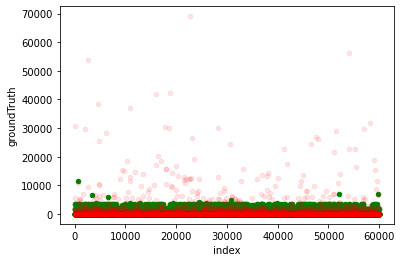

In [35]:
ax = y_pred_pandas.reset_index().plot(kind="scatter", x="index", y="prediction", color="green")
y_pred_pandas.reset_index().plot(kind="scatter", x="index", y="groundTruth", color='r', ax=ax, alpha=.1)

Notre modèle n'arrive pas à différencier les comportements et donne donc la moyenne

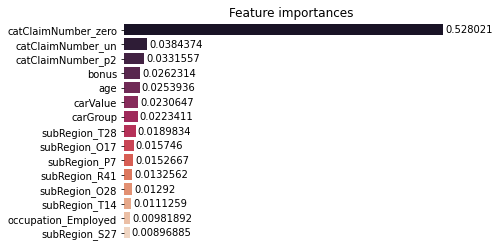

In [36]:
# Organizing feature names and importances in a DataFrame
features_df = pd.DataFrame({'features': rfr.feature_names_in_, 'importances': rfr.feature_importances_ })

# Sorting data from highest to lowest
features_df_sorted = features_df.sort_values(by='importances', ascending=False)[:15]

# Barplot of the result without borders and axis lines
g = sns.barplot(data=features_df_sorted, x='importances', y ='features', palette="rocket")
sns.despine(bottom = True, left = True)
g.set_title('Feature importances')
g.set(xlabel=None)
g.set(ylabel=None)
g.set(xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def plot_learning_curves(model, X_train, X_val, y_train, y_val):
    """ Plot the learning curves of the training set and the validation set for the given model.
    """
    train_errors, val_errors = [], []
    for m in range(100, X_train.shape[0] + 1, 5000):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    
    plt.plot(train_errors, 'r-+', linewidth=2, label='train')
    plt.plot(val_errors, 'b-', linewidth=3, label='val')
    plt.legend(loc="upper right")
    plt.xlabel("Training set size")
    plt.ylabel("MSE loss")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   38.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[

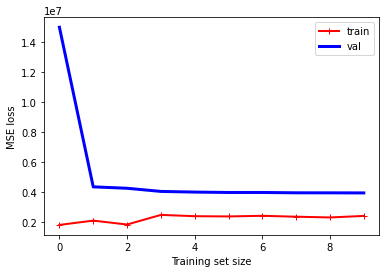

In [40]:
plot_learning_curves(rfr, X_train_claimValue, X_val_claimValue, y_train_claimValue, y_val_claimValue)
plt.show()

Underfit